# Inteligencja obliczeniowa - Projekt 1
**Autor:** *Paweł Olszewski*

## Wstęp

Poniższa praca opisuje moje implementacje algorytmów inspirowanych biologicznie rozwiązujących nonogramy czyli japońskie łamigłówki polegające na tworzeniu obrazków po przez zamalowywanie odpowiednich pixeli zgodnie ze wzorami zawartymi na krawędziach planszy. Zamalowane pixele tworzą bloki których kolejność, długość i kolor muszą zgadzać się z szablonem podanym na początku rzędu bądź kolumny. W przyadku jednokolorowych bloków musi być zachowana między nimi przerwa co najmniej jednego pixela.

W dalszej części pracy zostały opisane algorytmy:
- Dwa algorytmy genetyczne rozwiązujące problem dla czarno białych nonogramów
- Dwa algorytmy typu rój cząstek rozwiązujące problem dla czarno białych nonogramów
- Dwa algorytmy genetyczne rozwiązujące problem dla kolorowych nonogramów

## Przygotowanie środowiska

Czarno białe nonogramy zostały zakodowane jako listy wzorów w jakie układają się bloki zamalowanych pixeli, a kolorowe nonogramy dodatkowo przechowują informacje na temat koloru *(zakodowanego za pomocą RGB)* każdego bloku we wzorze.

In [1]:
import piplite
await piplite.install('pygad')
await piplite.install('pyswarms')

import pygad
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

# statek 10x10
verticalM10 = [[1,1],[1,2,1],[2,3],[3,2,1],[4,3],[8,1],[3],[2,1],[1,1],[1]]
horizontalM10 = [[1],[2],[3],[4],[5],[1,2],[8],[6],[1,1,1,1,1],[1,1,1,1,1]]

# kaczka 10x10
verticalM102 = [[1],[2,3],[4,1,1],[1,3],[1,1,1,2],[1,1,2],[4,1,1],[1,1],[1,1],[5]]
horizontalM102 = [[3],[1,1],[1,1,1],[3,1],[5,1],[1,1,1],[1,4],[1,1,1],[1,2,2],[2,3,1]]

# motyl 15x15
verticalM = [[3,2],[1,3,2],[2,1,2,1],[2,1,1],[2,1],[1,2,1],[6,6],[11],[6,6],[1,1,1],[1,1,1],[1,1],[1,1,2,1],[1,1,2],[3]]
horizontalM = [[1,1],[1,1],[1,1],[1,1],[1,3],[3,3],[1,2,3,3],[1,1,2,1,1,1],[1,5,1,1],[2,3,1],[2,3,1],[1,3,1],[1,1,3,1,1],[2,5,1],[4,1,4]]

# papuga 15x15
verticalM15 = [[5,2],[2,1,1,2],[1,3,2],[1,1,2,2],[1,2,2,2],[2,1,4,1],[5,1,2],[2,2,4],[2,1,1,2],[1,2,2,2],[2,2,1],[2,7],[2,2,2],[2,2,2],[5,1]]
horizontalM15 = [[5],[2,2],[1,1,3],[3,5],[1,1,2,2],[4,2,2],[1,3,2],[2,2,2],[2,2,1],[2,2,1],[2,3,4],[4,1,1,1,2],[5,3,1],[6,3],[6]]

# ptak 15x14
verticalMColor = [[[1,1]],[[1,1],[2,1]],[[2,1],[4,1]],[[1,2],[6,1]],[[3,2],[4,1]],[[4,2],[2,1],[1,3]],[[3,2],[2,1],[3,3]],[[1,1],[2,2],[1,1],[3,3]],[[2,1],[1,2],[1,1],[3,3],[2,1]],[[5,1],[5,3],[1,1]],[[4,1],[5,3]],[[2,1],[1,1],[4,3]],[[3,1],[2,3]],[[1,1]],[[1,1]]]
horizontalMColor = [[[3,1]],[[5,1]],[[4,1],[3,1]],[[4,2],[4,1]],[[4,2],[1,1],[3,3]],[[3,2],[1,1],[4,3]],[[3,2],[1,1],[3,3]],[[6,1],[4,3]],[[5,1],[5,3]],[[2,1],[5,3]],[[3,1],[2,3],[1,1]],[[3,1],[2,1]],[[4,1]],[[1,1]]]
colors = {1: [0, 0, 0], 2: [110, 110, 110], 3: [176, 30, 30]}

# pszczoła 10x10
verticalMColor10x10 = [[[3,1]],[[1,1],[3,2],[1,1]],[[3,1],[2,1],[1,1],[2,1],[1,1]],[[1,1],[1,1],[5,2],[1,1]],[[1,1],[8,1]],[[1,1],[1,1],[5,3],[1,1]],[[1,1],[7,1]],[[1,1],[1,1],[1,1],[3,3],[1,1]],[[1,1],[3,1]],[[1,1]]]
horizontalMColor10x10 = [[[2,1],[2,1]],[[1,1],[1,1],[1,1]],[[1,1],[1,1],[1,1]],[[5,1]],[[1,1],[2,2],[1,1],[1,2],[2,1]],[[1,1],[3,2],[1,1],[1,2],[1,1],[1,2],[1,1]],[[1,1],[1,2],[1,1],[1,2],[1,1],[1,2],[1,1],[1,2],[2,1]],[[1,1],[3,2],[1,1],[1,2],[1,1],[1,2],[1,1]],[[1,1],[2,2],[1,1],[1,2],[2,1]],[[5,1]]]
colors10x10 = {1: [0, 0, 0], 2: [255, 238, 0]}

# motyl kolorowy 9x9
verticalMColor9x9 = [[[2,1]],[[1,1],[2,2],[1,1],[1,1]],[[1,1],[1,2],[1,3],[1,2],[1,1],[1,2],[1,1]],[[1,1],[1,2],[2,3],[1,2],[1,1]],[[4,1]],[[1,1],[1,2],[2,3],[1,2],[1,1]],[[1,1],[1,2],[1,3],[1,2],[1,1],[1,2],[1,1]],[[1,1],[2,2],[1,1],[1,1]],[[2,1]]]
horizontalMColor9x9 = [[],[[2,1],[2,1]],[[1,1],[2,2],[1,1],[1,1],[2,2],[1,1]],[[1,1],[1,2],[1,3],[1,2],[1,1],[1,2],[1,3],[1,2],[1,1]],[[1,1],[1,2],[1,3],[1,1],[1,3],[1,2],[1,1]],[[1,1],[1,3],[1,1],[1,3],[1,1]],[[1,1],[1,2],[1,1],[1,2],[1,1]],[[2,1],[2,1]],[]]
colors9x9 = {1: [0, 0, 0], 2: [255, 196, 0], 3: [255, 238, 0]}


# 1. Pierwsza wersja algortmu genetycznego

## Opis
Pierwsza wersja algorytmu działa na prostej zasadzie, traktuje każdy pixel obrazka jako osobny gen **(num_genes = height\*width)** który może być albo zamalowany albo pusty **(genes_pace = [0, 1])**. Po losowym przydzieleniu wartości dla każdego pixela funkcja **fitness_func** ocenia rozwiązanie, porównując wzory w jakie układają się zamalowane bloki do wzorów które opisują obrazek, dla każdego rzędu i kolumny obrazka. Korzysta ona z funkcji **gradeFunc** która po otrzymaniu listy pixeli *(postaci [1, 0, 0, 0, 1, 1])* i wzoru *(postaci [1,2])*:
- tworz z pierwszego parametru drugi wzór
- porównuje ilość zamalowanych pixeli w obu wzorach *(jeden pixel różnicy jeden punkt ujemny)*
- porównuje każy element obu wzorów *(jeśli n'ty element wyenerowanego wzoru nie zgadza się z n'tym elementem orginalnego wzoru to odejmuje różnicę długości tych elementów od ogólnego wyniku, a jeśli wzory nie są równej długości to dodatkowo odejmuję długości nadmiarowych bloków)*
- zwaraca ilość ujemnych punktów

Algorytm kończy się gdy rozwiąże nonogram lub gdy przez dwieście generacji najlepszy wynik się nie zmieni. Po zakończeniu program wypisze ilość generacji jaką mu zajęło odnajdywanie wyniku, dopasowanie *(Fitness)* odnalezionego wyniku oraz wyświetli wykres jak zmieniało się dopasowanie najlepszego rozwiązania oraz wyświetli wygenerowany obrazek. W przypadku nie odnalezienia poprawnego rozwiązania funkcja dodatkowo wypisze w konsoli wszystkie rzędy i kolumny z których składa się obrazek, wraz z ich punktacją.

## Podsumowanie
Ta wersja algorytmu potrafi bezbłędnie rozwiązać nonogram wielkości 10x10 w bardzo krótkim czasie, aczkolwiek nie zawsze jej się udaje.

Na sto uruchomień algorytmu dla nonogramu 10x10 *(statek)* średni czas działania to: **10.62s**, a średnie dopasowanie: **-4.74**. **20** rozwiązań było poprawnych *(fitness = 0)* co stnowi **20%** wszystkich roziązań. Średnia ilość generacji algorytmu to **320.59**.

Na sto uruchomień algorytmu dla nonogramu 15x15 *(motyl)* średni czas działania to: **33.3s**, a średnie dopasowanie: **-25.58**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **-12**. Średnia ilość generacji algorytmu to **556.23**.

>Zauważyłem że wszystkie stwożone przeze mnie algorytmy działją najlepiej gdy wartość **mutation_percent_genes** jest możliwie najmniejsza, lecz co ważne nie *zerowa*, więc napisałem funkcję **getPercentageOfMutations(num_genes)** która dobiera ten parametr w taki sposób aby tylko jeden gen był wybierany do mutowania. Ta funkcja jest użyta we wszystkich algorytmach opisanych w tej pracy

## Kod

Generations: 418 Fitness: -2
Mistakes in paterns:
rows
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 0
[0. 0. 0. 0. 1. 1. 0. 0. 0. 0.] 0
[0. 0. 0. 1. 1. 1. 0. 0. 0. 0.] 0
[0. 0. 1. 1. 1. 1. 0. 0. 0. 0.] 0
[0. 1. 1. 1. 1. 1. 0. 0. 0. 0.] 0
[1. 0. 0. 0. 0. 1. 0. 1. 0. 0.] -2
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0.] 0
[0. 1. 1. 1. 1. 1. 1. 0. 0. 0.] 0
[1. 0. 1. 0. 1. 0. 1. 0. 1. 0.] 0
[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.] 0
columns
[0, 0, 0, 0, 0, 1, 0, 0, 1, 0] 0
[0, 0, 0, 0, 1, 0, 1, 1, 0, 1] 0
[0, 0, 0, 1, 1, 0, 1, 1, 1, 0] 0
[0, 0, 1, 1, 1, 0, 1, 1, 0, 1] 0
[0, 1, 1, 1, 1, 0, 1, 1, 1, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1] 0
[0, 0, 0, 0, 0, 0, 1, 1, 1, 0] 0
[0, 0, 0, 0, 0, 1, 1, 0, 0, 1] 0
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 0
░░░░░░░░░░██░░░░░░░░
░░░░░░░░████░░░░░░░░
░░░░░░██████░░░░░░░░
░░░░████████░░░░░░░░
░░██████████░░░░░░░░
██░░░░░░░░██░░██░░░░
░░████████████████░░
░░████████████░░░░░░
██░░██░░██░░██░░██░░
░░██░░██░░██░░██░░██


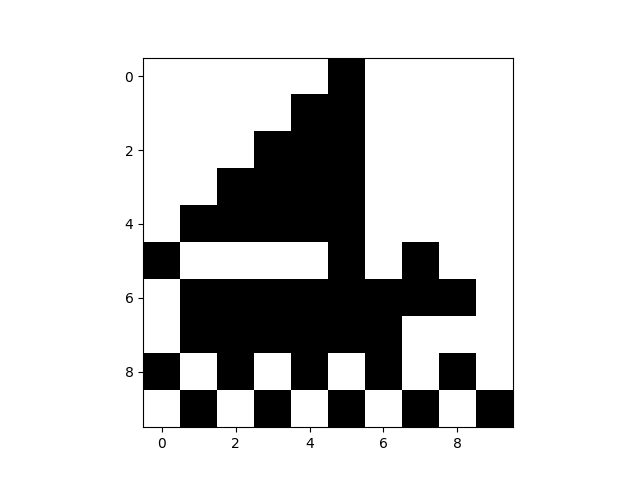

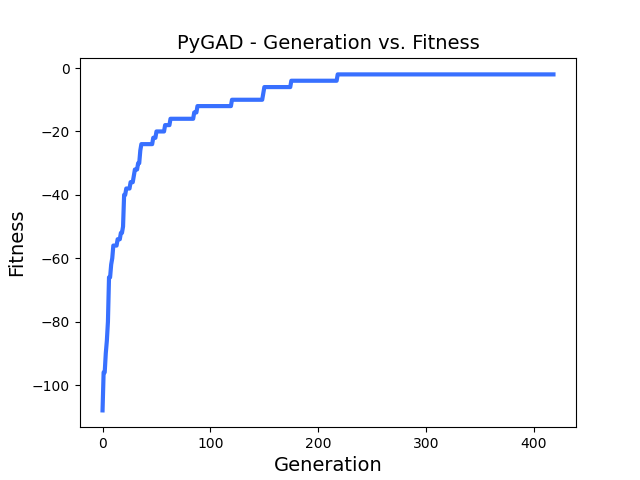

In [2]:
def getPercentageOfMutations(num_genes):
    return 100/num_genes

def runAlgorythmV1(verticalPattern, horizontalPattern):
    height = len(verticalPattern)
    width = len(horizontalPattern)

    def createImg(genes, height, width):
        img = np.zeros((height, width))
        index = 0
        for i in range(height):
            for j in range(width):
                img[i][j] = abs(genes[index]-1)
                index += 1
        
        return img

    def gradeFunc(solution, pattern):
        solutionPattern = [0]
        for i in solution:
            if i == 0:
                solutionPattern.append(0)
            else:
                if solutionPattern[-1] != 0:
                    solutionPattern[-1] = solutionPattern[-1] + 1
                else:
                    solutionPattern.append(1)
        filteredRowPatern = list(filter(lambda n: n != 0 , solutionPattern))

        grade = -abs(sum(pattern) - sum(filteredRowPatern))

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i] - filteredRowPatern[i])
            else:
                grade -= pattern[i]

        if len(filteredRowPatern) > len(pattern):
            for i in range(len(filteredRowPatern) - len(pattern)):
                grade -= filteredRowPatern[i + len(pattern)]

        return grade

    def fitness_func(solution, solution_idx):
        rowsGrade = 0
        for i in range(height):
            row = solution[i * width: i * width + width]
            grade = gradeFunc(row, horizontalPattern[i])
            rowsGrade += grade

        columnsGrade = 0
        for i in range(width):
            column = []
            for j in range(height):
                column.append(solution[j * height + i])
            grade = gradeFunc(column, verticalPattern[i])
            columnsGrade += grade

        fitness = rowsGrade + columnsGrade
        return fitness

    gene_space = [0, 1]
    num_genes = height * width
    fitness_function = fitness_func
    sol_per_pop = 100

    num_parents_mating = 42
    num_generations = 5000
    keep_parents = 6
    parent_selection_type = "sss"
    crossover_type = "single_point"
    mutation_type = "random"
    mutation_percent_genes = getPercentageOfMutations(num_genes)
    stop_criteria = ["reach_0", "saturate_200"]

    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=stop_criteria)
    ga_instance.run()
    print("Generations:", ga_instance.generations_completed, "Fitness:", ga_instance.best_solution()[1])

    genes = ga_instance.best_solution()[0]

    if ga_instance.best_solution()[1] != 0:
        print("Mistakes in paterns:")

        print("rows")
        for i in range(height):
                row = genes[i * width: i * width + width]
                grade = gradeFunc(row, horizontalPattern[i])
                print(row, grade)

        print("columns")
        for i in range(width):
            column = []
            for j in range(height):
                column.append(int(genes[j * height + i]))
            grade = gradeFunc(column, verticalPattern[i])
            print(column, grade)

    img = createImg(genes, height, width)

    # wyświetlanie wygenerowanego obrazka w konsoli
    for i in range(height):
            for j in range(width):
                if img[i][j] == 0:
                    print("██", end="")
                else:
                    print("░░", end="")
            print("")

    plt.imshow(img, cmap="gray")
    plt.show()
    ga_instance.plot_fitness()
    return ga_instance

runAlgorythmV1(verticalM10, horizontalM10)

# 2. Druga wersja algortmu genetycznego

## Opis
Druga wersja algorytmu jest bardziej zawansowana, traktuje każdy blok pixeli ze wszystkich poziomych reguł jako osobny gen **(num_genes = getNumberOfBlocks(horizontalPattern))**. Geny są z przedziału od 0 do szerokości obrazka **(gene_space = list(range(0, width)))** i oznaczają index od którego dany blok się zaczyna *(każdy rząd jest zakodowany jako lista)*. Funkcja **fitness_func** w tym przypadku:
- tworzy wzory i obrazek z wygenerowanych wartości dla każdego rzędu
- sprawdza czy wygenerowane wzory dla każdego rzędu są poprawne
  - czy bloki są ułożone w odpowiedniej kolejności *(jeden błąd 1000 punktów karnych)*
  - czy są zachowane przerwy między blokami *(jeden błąd 1000 punktów karnych)*
  - czy bloki nie wychodzą poza wiersz *(jeden błąd 10000 punktów karnych)*
- ocenia kolumny obrazka *(na tej samej zasadzie co gradeFunc z pierwszej wersji algorytmu)*

>W tej wersji algorytmu parametr **crossover_type** ma wartość **"two_points"** ponieważ podczas testów zauważyłem że dzięki temu algorytm działa optymalniej.

Podobnie jak poprzednia wersja algorytm kończy się gdy rozwiąże nonogram lub gdy przez dwieście generacji najlepszy wynik się nie zmieni. Po zakończeniu program wypisze ilość generacji jaką mu zajęło odnajdywanie wyniku, dopasowanie *(Fitness)* odnalezionego wyniku oraz wyświetli wykres jak zmieniało się dopasowanie najlepszego rozwiązania oraz wyświetli wygenerowany obrazek. W przypadku nie odnalezienia poprawnego rozwiązania funkcja dodatkowo wypisze w konsoli wszystkie kolumny z których składa się obrazek, wraz z ich punktacją.

## Podsumowanie
Ta wersja algorytmu potrafi rozwiązać nonogram wielkości 10x10 z większym prawdopodobieństwem sukcesu niż poprzednia generacja, aczkolwiek działa o wiele dłużej. Nonogram 15x15 stanowi dla niej problem, aczkolwiek zazwyczaj bezproblemowo da się rozpoznać co znajduje się na szukanym obrazku. Co ciekawe mimo że średnie dopasowanie dla nonogramu 15x15 jest gorsze, to najlepsze dopasowanie jest lepsze niż w poprzedniej wersji.

Na sto uruchomień algorytmu dla nonogramu 10x10 *(statek)* średni czas działania to: **21.21s**, a średnie dopasowanie: **-6.18**. **30** rozwiązań było poprawnych *(fitness = 0)* co stnowi **30%** wszystkich roziązań. Średnia ilość generacji algorytmu to **325.49**.

Na sto uruchomień algorytmu dla nonogramu 15x15 *(motyl)* średni czas działania to: **75.1s**, a średnie dopasowanie: **-37.26**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **-8**. Średnia ilość generacji algorytmu to **622.75**.

## Kod

Generations: 399 Fitness: -4


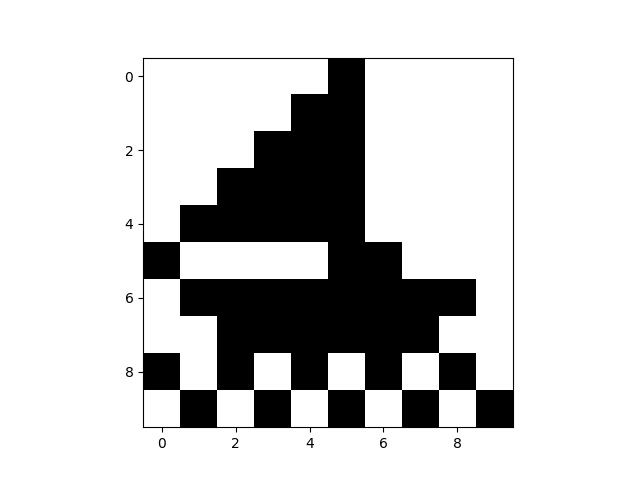

Mistakes in vertical paterns:
[1, 1, 1, 1, 1, 0, 1, 1, 0, 1] 0
[1, 1, 1, 1, 0, 1, 0, 1, 1, 0] -2
[1, 1, 1, 0, 0, 1, 0, 0, 0, 1] 0
[1, 1, 0, 0, 0, 1, 0, 0, 1, 0] 0
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1] 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 0
[1, 1, 1, 1, 1, 0, 0, 0, 0, 1] -2
[1, 1, 1, 1, 1, 1, 0, 0, 1, 0] 0
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1] 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0] 0
░░░░░░░░░░██░░░░░░░░
░░░░░░░░████░░░░░░░░
░░░░░░██████░░░░░░░░
░░░░████████░░░░░░░░
░░██████████░░░░░░░░
██░░░░░░░░████░░░░░░
░░████████████████░░
░░░░████████████░░░░
██░░██░░██░░██░░██░░
░░██░░██░░██░░██░░██


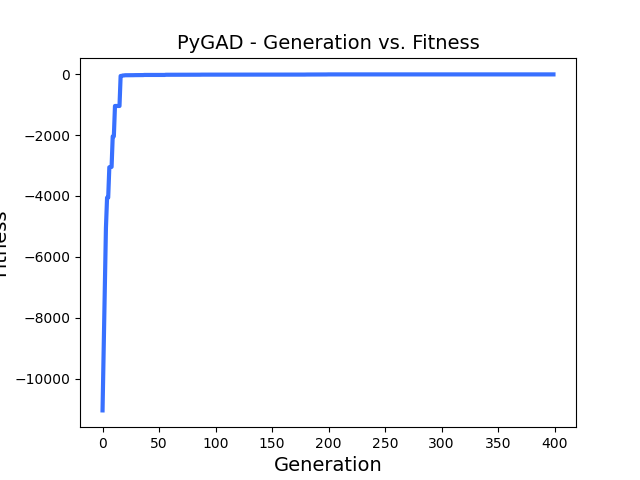

In [3]:
def runAlgorythmV2(verticalPattern, horizontalPattern):
    height = len(horizontalPattern)
    width = len(verticalPattern)

    def createImgV2(genes, height, width, horizontalPattern):
        img = np.ones((height, width), dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            for j in horizontalPattern[i]:
                start = int(genes[index])
                if start + j <= width :
                    for n in range(j):
                        img[i][start + n] = 0
                else:
                    for n in range(width - start):
                        img[i][start + n] = 0
                index += 1
        
        return img

    def gradeFuncV2(solution, pattern):
        # tworzenie "wzoru" z wygenerowanych wartości
        solutionPattern = [-1]
        for i in solution:
            if i == 1:
                solutionPattern.append(-1)
            else:
                if solutionPattern[-1] != -1:
                    solutionPattern[-1] = solutionPattern[-1] + 1
                else:
                    solutionPattern.append(1)
        filteredRowPatern = list(filter(lambda n: n != -1 , solutionPattern))
        # ocenianie wygenerowaniego "wzoru"
        grade = -abs(sum(pattern) - sum(filteredRowPatern))

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i] - filteredRowPatern[i])
            else:
                grade -= pattern[i]

        if len(filteredRowPatern) > len(pattern):
                for i in range(len(filteredRowPatern) - len(pattern)):
                    grade -= filteredRowPatern[i + len(pattern)]

        return grade

    def gradeGenPatternV2(pattern):
        # pattern[i][0] początek bloku
        # pattern[i][0] + pattern[i][1] ostatni index zajmowany przez ten blok (długość bloku + 1 miejsce przerwy)
        grade = 0
        for i in range(len(pattern)):
            # prównywanie obecnego bloku do wszystkich poprzednich
            for j in range(i):
                if pattern[j][0] + pattern[j][1] >= pattern[i][0]:
                    grade -= 1000
        return grade

    def fitness_func(solution, solution_idx):
        fitness = 0
        # tworzenie macieży
        img = np.ones((height, width), dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            generatedPattern = []
            for j in horizontalPattern[i]:
                start = int(solution[index])
                generatedPattern.append([solution[index], j])
                if start + j <= width :
                    for n in range(j):
                        img[i][start + n] = 0
                else:
                    for n in range(width - start):
                        img[i][start + n] = 0
                    # odejmuj punkty gdy blok wychodzi poza wiersz
                    fitness -= abs(width - start - j)*10000
                index += 1
            fitness -= abs(gradeGenPatternV2(generatedPattern))
        # ocenianie kolumn
        for i in range(width):
            column = []
            for j in range(height):
                column.append(img[j][i])
            fitness += gradeFuncV2(column, verticalPattern[i])

        return fitness

    def getNumberOfBlocks(pattern):
        num = 0
        for i in pattern:
            num += len(i)
        return num

    gene_space = list(range(0, width))
    num_genes = getNumberOfBlocks(horizontalPattern)
    fitness_function = fitness_func
    sol_per_pop = 200

    num_parents_mating = 99
    num_generations = 5000
    keep_parents = 2
    parent_selection_type = "sss"
    # crossover_type = "single_point" # two points działa znacznie lepiej
    crossover_type = "two_points"
    mutation_type = "random"
    mutation_percent_genes = getPercentageOfMutations(num_genes) # im mniejsza wartość tym lepiej

    stop_criteria = ["reach_0", "saturate_200"]

    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=stop_criteria)
    ga_instance.run()
    print("Generations:", ga_instance.generations_completed, "Fitness:", ga_instance.best_solution()[1])
    genes = ga_instance.best_solution()[0]

    img = createImgV2(genes, height, width, horizontalPattern)
    plt.imshow(img, cmap="gray")
    plt.show()

    if ga_instance.best_solution()[1] != 0:
        print("Mistakes in vertical paterns:")
        for i in range(width):
            column = []
            for j in range(height):
                column.append(img[j][i])
            print(column, gradeFuncV2(column, verticalPattern[i]))

    for i in range(height):
        for j in range(width):
            if img[i][j] == 0:
                print("██", end="")
            else:
                print("░░", end="")
        print("")

    ga_instance.plot_fitness()
    return ga_instance

runAlgorythmV2(verticalM10, horizontalM10)

Generations: 463 Fitness: -24


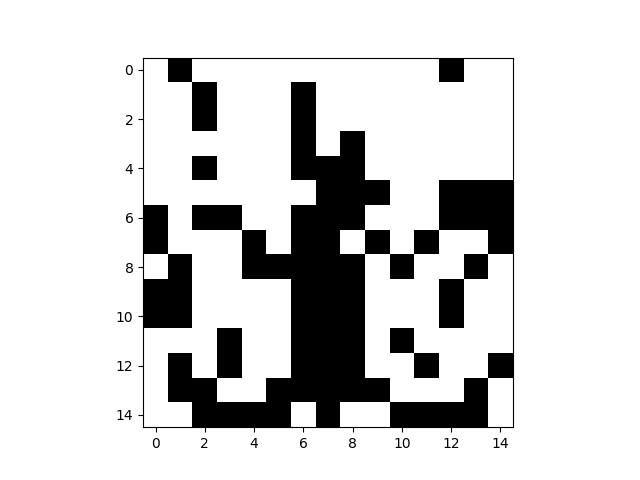

Mistakes in vertical paterns:
[1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1] -2
[0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1] 0
[1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0] -2
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0] -2
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0] -2
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1] -4
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1] -4
[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1] 0
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0] 0
[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0] -2
[0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0] -2
[1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0] -2
[1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1] -2
░░██░░░░░░░░░░░░░░░░░░░░██░░░░
░░░░██░░░░░░██░░░░░░░░░░░░░░░░
░░░░██░░░░░░██░░░░░░░░░░░░░░░░
░░░░░░░░░░░░██░░██░░░░░░░░░░░░
░░░░██░░░░░░██████░░░░░░░░░░░░
░░░░░░░░░░░░░░██████░░░░██████
██░░████░░░░██████░░░░░░██████
██░░░░░░██░░████░░██░░█

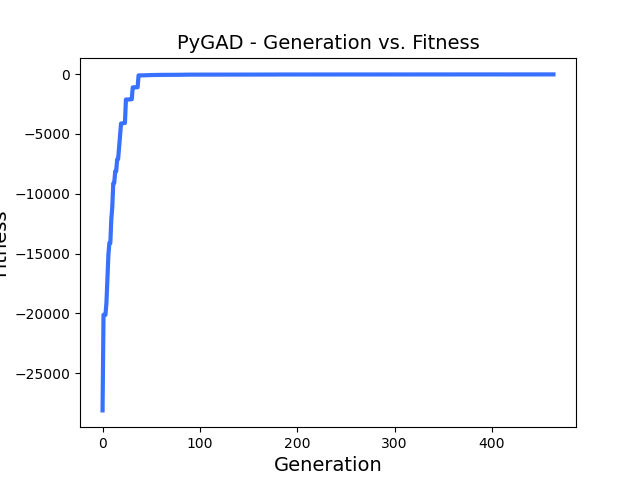

In [4]:
runAlgorythmV2(verticalM, horizontalM)

# 3. Pierwsza wersja algortmu typu rój cząstek

## Opis

Pierwsza wersja algorytmu typu rój cząstek jest analogiczna do pierwszej wersji algorytmu genetycznego. Liczba wymiarów przestrzeni po której poruszają się cząstki jest równa liczbie pixeli z których składa się podany nonogram **(dimensions=height\*width)**, dodatkowo przestrzeń każdego z wymiarów zstała ograniczona do przedziału (0,1) **(bounds=my_bounds)**. Z powodu że każdy wymiar jest zapisany jako liczba przecinkowa funkcja oceniająca zaokrągla wszystkie wartości, dzięki czemu jej logika jest praktycznie niezmieniona względem funkcji fitness_func z pierwszej wersji algorytmu genetycznego.

>Z powodu że algorytm typu rój cząstek szuka minimum (w przeciwieństwie do powyższych algorytmów genetycznych) ogólny wynik funkcji jest dodatni lub równy 0 (im większy tym gorszy)

Po zakończeniu działania funkcja wyświetla najlepszy odnaleziony wynik waraz z jego dopasowaniem oraz wyświetla wykres jak zmieniało się dopasowanie najlepszego rozwiązania i wyświetli wygenerowany obrazek.

## Podsumowanie
Ta wersja jest znacznie gorsza niż algorytm genetyczny i nonogram o rozmiarze 10x10 stanowi dla niej spory problem.

Na dziesięć uruchomień algorytmu dla nonogramu 10x10 *(statek)* średni czas działania to: **69.95s**, a średnie dopasowanie: **34.2**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **20**. Każde uruchomienie symulowało **1000** iteracji i **100** cząstek.

Na dziesięć uruchomień algorytmu dla nonogramu 15x15 *(motyl)* średni czas działania to: **155.17s**, a średnie dopasowanie: **94.6**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **76**. Każde uruchomienie symulowało **1000** iteracji i **100** cząstek.

## Kod

2022-04-26 22:11:44,654 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
/lib/python3.10/site-packages/tqdm/std.py:1541: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  return tqdm(_range(*args), **kwargs)
pyswarms.single.global_best: 100%|##########|1000/1000, best_cost=36
2022-04-26 22:14:31,721 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 36.0, best pos: [0.31029091 0.19875976 0.75679153 0.43733381 0.44579846 0.36575587
 0.42974522 0.28477707 0.42781221 0.45368676 0.30017902 0.3491542
 0.46284906 0.50866614 0.50339793 0.58940841 0.38249919 0.41212073
 0.48019583 0.4214263  0.49246737 0.49822982 0.57143948 0.50724942
 0.62067028 0.51088209 0.41751598 0.22231924 0.39987697 0.25916757
 0.31324024 0.25292179 0.54836576 0.67058398 0.70673245 0.66361303
 0.22882596 0.32508082 0.4719294  0.35147175 0.72341846 0.6291485
 0.62287865 0.46215082 0.56339032

░░░░██░░░░░░░░░░░░░░
░░░░░░██████░░░░░░░░
░░░░████████░░░░░░░░
░░░░████████░░░░░░░░
██████░░████░░░░░░░░
░░░░░░██░░████░░░░░░
░░░░████████████████
████░░░░██████░░░░░░
░░██░░██░░██░░██░░░░
██░░░░░░██░░░░██░░░░


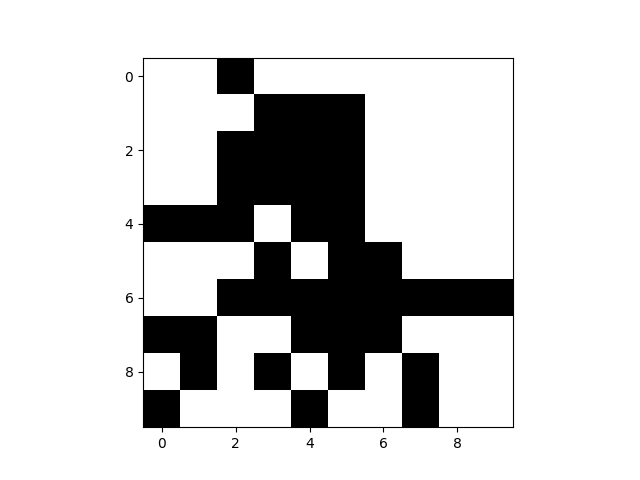

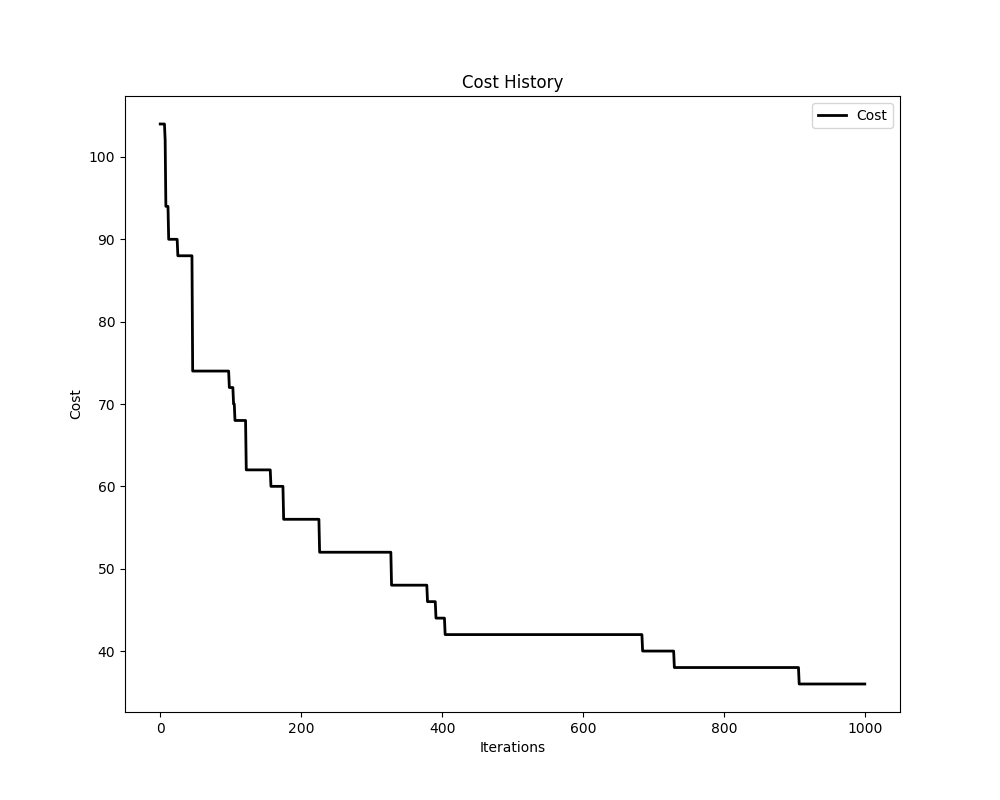

(36.0,
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.]))

In [5]:
def runAlgorythmSwarmV1(verticalPattern, horizontalPattern):     
    height = len(verticalPattern)
    width = len(horizontalPattern)
    x_max = np.ones(height*width, dtype=int)
    x_min = np.zeros(height*width, dtype=int)
    my_bounds = (x_min, x_max)
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

    def fitness_func(solution):
        rowsGrade = 0
        for i in range(height):
            row = solution[i * width: i * width + width]
            grade = gradeFunc(row, horizontalPattern[i])
            rowsGrade += grade

        columnsGrade = 0
        for i in range(width):
            column = []
            for j in range(height):
                column.append(solution[j * height + i])
            grade = gradeFunc(column, verticalPattern[i])
            columnsGrade += grade

        fitness = rowsGrade + columnsGrade
        return fitness

    def gradeFunc(solution, pattern):
        solutionPattern = [0]
        for i in solution:
            if round(i) == 0:
                solutionPattern.append(0)
            else:
                if solutionPattern[-1] != 0:
                    solutionPattern[-1] = solutionPattern[-1] + 1
                else:
                    solutionPattern.append(1)
        filteredRowPatern = list(filter(lambda n: n != 0 , solutionPattern))

        grade = -abs(sum(pattern) - sum(filteredRowPatern))

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i] - filteredRowPatern[i])
            else:
                grade -= pattern[i]

        if len(filteredRowPatern) > len(pattern):
            for i in range(len(filteredRowPatern) - len(pattern)):
                grade -= filteredRowPatern[i + len(pattern)]

        return grade

    def createImg(genes, height, width):
        img = np.zeros((height, width))
        index = 0
        for i in range(height):
            for j in range(width):
                img[i][j] = abs(genes[index]-1)
                index += 1
        
        return img

    def f(swarm):
        n_particles = swarm.shape[0]
        j = [-fitness_func(swarm[i]) for i in range(n_particles)]
        return np.array(j)

    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=height*width, options=options, bounds=my_bounds)
    result = optimizer.optimize(f, iters=1000)

    pixels = result[1]
    for i in range(len(pixels)):
        pixels[i] = round(pixels[i])
        
    img = createImg(pixels, height, width)

    for i in range(height):
        for j in range(width):
            if img[i][j] == 0:
                print("██", end="")
            else:
                print("░░", end="")
        print("")

    plt.imshow(img, cmap="gray")
    plt.show()

    plot_cost_history(optimizer.cost_history)
    plt.show()
    
    return result

runAlgorythmSwarmV1(verticalM10, horizontalM10)

# 4. Druga wersja algortmu typu rój cząstek

## Opis

Druga wersja algorytmu typu rój cząstek działa na tej samej zasadzie co druga wersja algorytmu genetycznego. Liczba wymiarów przestrzeni po której poruszają się cząstki jest równa liczbie wszystkich poziomych bloków pixeli z których składa się obrazek **(dimensions=blocks=getNumberOfBlocks(horizontalPattern))**, a przestrzeń każdego z wymiarów jest ograniczona od 0 do szerokości obrazka **(my_bounds = (\[0, ..., 0\], \[width, ..., width\]))**. Z powodu że każdy wymiar przestrzeni reprezentuje index od którego zaczyna się dany blok w rzędzie wszystkie wymiary zostają zaokrąglone w dół. Mając to na uwadze łatwo można zaobserwować że funcja oceniająca rozwiązanie będzie bardzo podobna do funkcji fitness_func z drugiego algorytmu genetycznego.

Po zakończeniu działania funkcja wyświetla najlepszy odnaleziony wynik waraz z jego dopasowaniem oraz wyświetla wykres jak zmieniało się dopasowanie najlepszego rozwiązania i wyświetli wygenerowany obrazek.

## Podsumowanie
Ta wersja algorytmu potrafi bezbłędnie rozwiązać nonogram 10x10, aczkolwiek jest bardzo czasochłonna i zauważalnie gorsza niż jej genetyczny odpowiednik.

Na dziesięć uruchomień algorytmu dla nonogramu 10x10 *(statek)* średni czas działania to: **245.67s**, a średnie dopasowanie: **117.4**. **1** rozwiązanie było poprawne *(fitness = 0)* co stnowi **10%** wszystkich roziązań. Każde uruchomienie symulowało **50** iteracji i **20000** cząstek.

Na dziesięć uruchomień algorytmu dla nonogramu 15x15 *(motyl)* średni czas działania to: **509.06s**, a średnie dopasowanie: **8606.8**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **6086**. Każde uruchomienie symulowało **50** iteracji i **20000** cząstek.

## Kod

2022-04-26 22:14:32,564 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|##########|50/50, best_cost=1040.0
2022-04-26 22:24:52,864 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1040.0, best pos: [4.81592734 3.17890842 4.55890288 0.18930179 1.50404323 4.39430914
 7.34524807 1.44029859 2.90283395 3.63168584 1.51168261 5.59739019
 7.7894018  9.23512429 0.3345415  2.6276692  4.39667347 7.28404275
 9.16160688]


Block positions:  [4. 3. 4. 0. 1. 4. 7. 1. 2. 3. 1. 5. 7. 9. 0. 2. 4. 7. 9.]


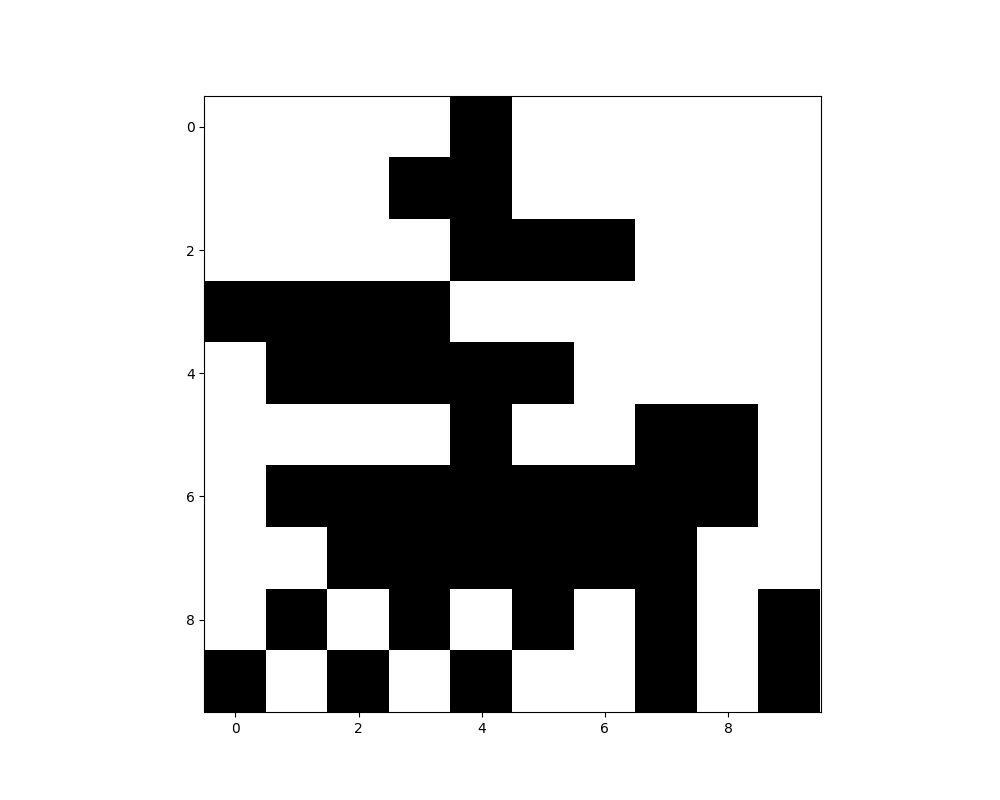

░░░░░░░░██░░░░░░░░░░
░░░░░░████░░░░░░░░░░
░░░░░░░░██████░░░░░░
████████░░░░░░░░░░░░
░░██████████░░░░░░░░
░░░░░░░░██░░░░████░░
░░████████████████░░
░░░░████████████░░░░
░░██░░██░░██░░██░░██
██░░██░░██░░░░██░░██


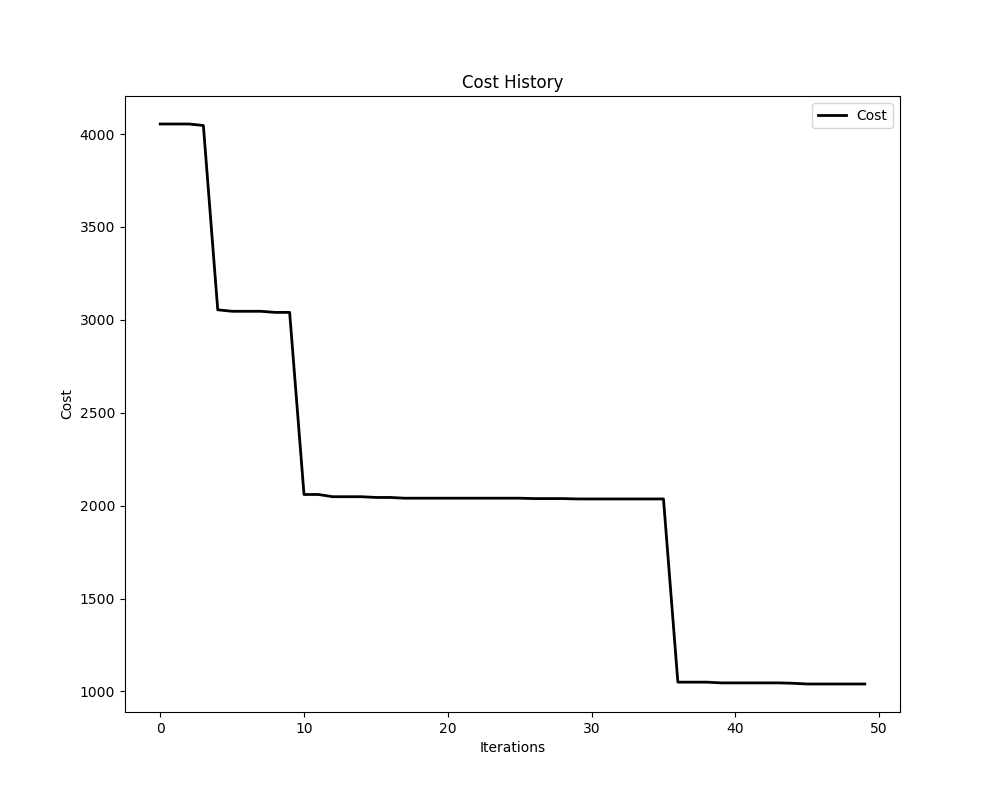

(1040.0,
 array([4., 3., 4., 0., 1., 4., 7., 1., 2., 3., 1., 5., 7., 9., 0., 2., 4.,
        7., 9.]))

In [6]:
def runAlgorythmSwarmV2(verticalPattern, horizontalPattern):
    def getNumberOfBlocks(pattern):
        num = 0
        for i in pattern:
            num += len(i)
        return num

    height = len(verticalPattern)
    width = len(horizontalPattern)
    blocks = getNumberOfBlocks(horizontalPattern)
    x_max = np.full((blocks), width, dtype=int)
    x_min = np.full((blocks), 0, dtype=int)
    my_bounds = (x_min, x_max)
    options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

    def gradeFuncV2(solution, pattern):
        solutionPattern = [-1]
        for i in solution:
            if i == 1:
                solutionPattern.append(-1)
            else:
                if solutionPattern[-1] != -1:
                    solutionPattern[-1] = solutionPattern[-1] + 1
                else:
                    solutionPattern.append(1)
        filteredRowPatern = list(filter(lambda n: n != -1 , solutionPattern))
        grade = -abs(sum(pattern) - sum(filteredRowPatern))

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i] - filteredRowPatern[i])
            else:
                grade -= pattern[i]

        if len(filteredRowPatern) > len(pattern):
            for i in range(len(filteredRowPatern) - len(pattern)):
                grade -= filteredRowPatern[i + len(pattern)]

        return grade

    def gradeGenPatternV2(pattern):
        grade = 0
        for i in range(len(pattern)):
            for j in range(i):
                if pattern[j][0] + pattern[j][1] >= pattern[i][0]:
                    grade -= 1000
                if pattern[j][0] == pattern[i][0]: # dodatkowe ujemne punkty żeby bloki na siebie nie nachodziły
                    grade -= 100000
        return grade

    def fitness_func(solution):
        fitness = 0
        img = np.ones((height, width), dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            generatedPattern = []
            for j in horizontalPattern[i]:
                start = int(solution[index])
                generatedPattern.append([floor(solution[index]), j])
                if start + j <= width :
                    for n in range(j):
                        img[i][start + n] = 0
                else:
                    for n in range(width - start):
                        img[i][start + n] = 0
                    fitness -= abs(width - start - j)*10000
                index += 1
            fitness += gradeGenPatternV2(generatedPattern)
        columnMistakes = 0
        for i in range(width):
            column = []
            for j in range(height):
                column.append(img[j][i])
            columnMistakes += gradeFuncV2(column, verticalPattern[i])

        return columnMistakes + fitness

    def createImgV2(genes, height, width, horizontalPattern):
        img = np.ones((height, width), dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            for j in horizontalPattern[i]:
                start = int(genes[index])
                if start + j <= width :
                    for n in range(j):
                        img[i][start + n] = 0
                else:
                    for n in range(width - start):
                        img[i][start + n] = 0
                index += 1
        
        return img

    def f(swarm):
        n_particles = swarm.shape[0]
        j = [-fitness_func(swarm[i]) for i in range(n_particles)]
        return np.array(j)

    optimizer = ps.single.GlobalBestPSO(n_particles=20000, dimensions=blocks, options=options, bounds=my_bounds)
    result = optimizer.optimize(f, iters=50)

    generatedPattern = result[1]
    for i in range(len(generatedPattern)):
        generatedPattern[i] = floor(generatedPattern[i])

    print("Block positions: ", generatedPattern)
    img = createImgV2(generatedPattern, height, width, horizontalPattern)
    plt.imshow(img, cmap="gray")
    plt.show()

    for i in range(height):
        for j in range(width):
            if img[i][j] == 0:
                print("██", end="")
            else:
                print("░░", end="")
        print("")

    plot_cost_history(optimizer.cost_history)
    plt.show()
    return result

runAlgorythmSwarmV2(verticalM10, horizontalM10)

# 5. Pierwsza wersja algortmu genetycznego rozwiązującego kolorowe nonogramy

## Opis

Pierwsza wersja algortmu genetycznego rozwiązującego kolorowe nonogramy jest bardzo podobna do pierwszej wersji algortmu genetycznego rozwiązującego czrno-białe nonogramy z tą różnicą że funkcja gradeFuncColor *(odpowiednik gradeFunc z wersji czeno-białej)*:

- Tworzy wzór z wygenerowanych wartości z uwzglendnieniem ich koloru
- Odejmuje punkty za różnice w ilości pixeli każdego z kolorów
- Porównuje każy element obu wzorów z uwzglendnieniem ich kolorów

Tak jak wszystkie poprzednie algorytmy genetyczne kończy się gdy rozwiąże nonogram lub gdy przez dwieście generacji najlepszy wynik się nie zmieni. Po zakończeniu program wypisze ilość generacji jaką mu zajęło odnajdywanie wyniku, dopasowanie (Fitness) odnalezionego wyniku oraz wyświetli wykres jak zmieniało się dopasowanie najlepszego rozwiązania oraz wyświetli wygenerowany obrazek. W przypadku nie odnalezienia poprawnego rozwiązania funkcja dodatkowo wypisze w konsoli wszystkie rzędy i kolumny z których składa się obrazek, wraz z ich punktacją.

## Podsumowanie
Okazuje się że nonogramy kolorowe są o wiele cięższe do rozwiązania dla algorytmu kożystającego z tego typu logki ponieważ bloki w które ustawiają się pixele są bardziej zwarte przez co algorytm znacznie częściej "wpada w minima lokalne" funkcji fitness_func. Co ciekawe algorytm działał lepiej dla większego nonogramu zarówno jeśli chodzi o średnie, jak i najlepsze dopasowanie.

Na sto uruchomień algorytmu dla nonogramu 10x10 *(pszczoła)* średni czas działania to: **22.93s**, a średnie dopasowanie: **-269.76**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **-230**. Średnia ilość generacji algorytmu to **476.59**.

Na dziesięć uruchomień algorytmu dla nonogramu 15x14 *(ptak)* średni czas działania to: **70.64s**, a średnie dopasowanie: **-231.1**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **-183**. Średnia ilość generacji algorytmu to **891.1**.

## Kod

Generations: 381 Fitness: -274
Mistakes in paterns:
rows
[0. 0. 1. 1. 1. 0. 0. 1. 0. 0.] -2
[0. 0. 0. 1. 2. 0. 1. 0. 0. 0.] -2
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0.] 0
[0. 1. 2. 2. 1. 1. 0. 0. 0. 0.] 0
[1. 0. 2. 2. 1. 0. 1. 1. 1. 0.] -6
[1. 1. 2. 0. 2. 1. 1. 1. 0. 1.] -17
[1. 0. 2. 2. 0. 1. 2. 0. 1. 0.] -49
[0. 2. 2. 2. 1. 0. 1. 1. 1. 0.] -32
[0. 1. 1. 0. 2. 0. 1. 0. 2. 0.] -24
[0. 1. 1. 1. 1. 0. 1. 0. 0. 0.] -2
columns
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0] 0
[0, 0, 0, 1, 0, 1, 0, 2, 1, 1] -8
[1, 0, 1, 2, 2, 2, 2, 2, 1, 1] -12
[1, 1, 0, 2, 2, 0, 2, 2, 0, 1] -16
[1, 2, 1, 1, 1, 2, 0, 1, 2, 1] -10
[0, 0, 0, 1, 0, 1, 1, 0, 0, 0] -57
[0, 1, 1, 0, 1, 1, 2, 1, 1, 1] -2
[1, 0, 0, 0, 1, 1, 0, 1, 0, 0] -35
[0, 0, 0, 0, 1, 0, 1, 1, 2, 0] 0
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 0


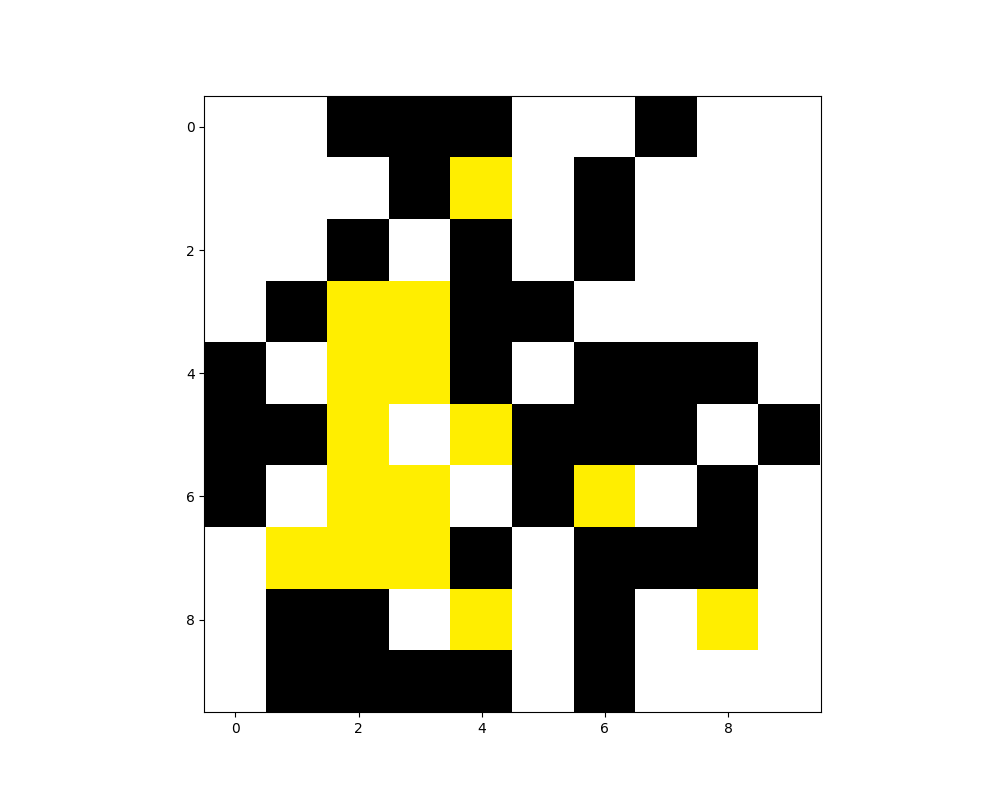

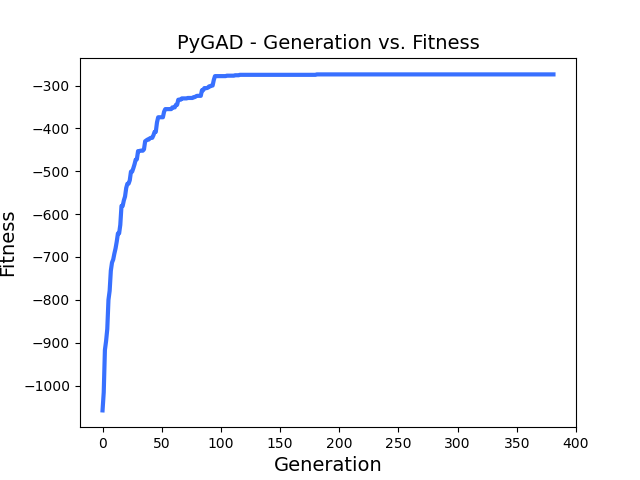

In [7]:
def runAlgorythmColorV1(verticalPattern, horizontalPattern, colors):
    height = len(horizontalPattern)
    width = len(verticalPattern)

    def createImgColor(genes, height, width):
        img = np.full((height, width, 3), 255, dtype=int)
        index = 0
        for i in range(height):
            for j in range(width):
                if genes[index] != 0:
                    img[i][j] = colors[genes[index]]
                index += 1
        
        return img

    def gradePaternsByColorLength(genPattern, pattern):
        # funkcja porównuje ile pixeli danego koloru jest w każdym wzorze
        grade = 0
        original = {}
        generated = {}
        for i in pattern: # i jest postaci [długość bloku, kolor]
            if i[1] in original:
                original[i[1]] = original[i[1]] + i[0]
            else:
                original[i[1]] = i[0]
        for i in genPattern:
            if i[1] in generated:
                generated[i[1]] = generated[i[1]] + i[0]
            else:
                generated[i[1]] = i[0]

        for i in original:
            if i in generated:
                grade -= abs(original[i] - generated[i])
                del generated[i]
            else:
                grade -= original[i]
        for i in generated:
            if i in original:
                grade -= abs(original[i] - generated[i])
            else:
                grade -= generated[i]

        return grade
        
    def gradeFuncColor(solution, pattern):
        # tworzenie "wzoru" z wygenerowanych wartości
        solutionPattern = [-1]
        for i in solution:
            if i == 0:
                solutionPattern.append(-1)
            else:
                if solutionPattern[-1] != -1:
                    solutionPattern[-1][0] = solutionPattern[-1][0] + 1
                else:
                    solutionPattern.append([1,i])
        filteredRowPatern = list(filter(lambda n: n != -1 , solutionPattern))
        # ocenianie wygenerowaniego "wzoru"
        grade = gradePaternsByColorLength(filteredRowPatern, pattern)*10

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i][0] - filteredRowPatern[i][0])
                    if pattern[i][1] != filteredRowPatern[i][1]: # wtedy gdy kolory są różne
                        grade -= pattern[i][0]
            else:
                grade -= pattern[i][0]

        if len(filteredRowPatern) > len(pattern):
            for i in range(len(filteredRowPatern) - len(pattern)):
                grade -= filteredRowPatern[i + len(pattern)][0]

        return grade

    def fitness_func(solution, solution_idx):
        rowsGrade = 0
        for i in range(height):
            row = solution[i * width: i * width + width]
            grade = gradeFuncColor(row, horizontalPattern[i])
            rowsGrade += grade

        columnsGrade = 0
        for i in range(width):
            
            column = []
            for j in range(height):
                column.append(solution[j * height + i])
            grade = gradeFuncColor(column, verticalPattern[i])
            columnsGrade += grade

        fitness = rowsGrade + columnsGrade
        return fitness
    
    gene_space = list(colors.keys()) + [0]
    num_genes = height * width
    fitness_function = fitness_func
    sol_per_pop = 100

    num_parents_mating = 42
    num_generations = 5000
    keep_parents = 6
    parent_selection_type = "sss"
    crossover_type = "single_point"
    # crossover_type = "two_points" # mniej efektywne
    mutation_type = "random"
    mutation_percent_genes = getPercentageOfMutations(num_genes)
    stop_criteria = ["reach_0", "saturate_200"]

    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=stop_criteria)
    ga_instance.run()
    print("Generations:", ga_instance.generations_completed, "Fitness:", ga_instance.best_solution()[1])

    genes = ga_instance.best_solution()[0]

    if ga_instance.best_solution()[1] != 0:
        print("Mistakes in paterns:")

        print("rows")
        for i in range(height):
            row = genes[i * width: i * width + width]
            grade = gradeFuncColor(row, horizontalPattern[i])
            print(row, grade)

        print("columns")
        for i in range(width):
            column = []
            for j in range(height):
                column.append(int(genes[j * height + i]))
            grade = gradeFuncColor(column, verticalPattern[i])
            print(column, grade)

    img = createImgColor(genes, height, width)

    plt.imshow(img, cmap="gray")
    plt.show()
    ga_instance.plot_fitness()
    return ga_instance

runAlgorythmColorV1(verticalMColor10x10, horizontalMColor10x10, colors10x10)

# 6. Druga wersja algortmu genetycznego rozwiązującego kolorowe nonogramy

## Opis

Druga wersja algortmu genetycznego rozwiązującego kolorowe nonogramy jest analogiczna do drugiej wersji algortmu genetycznego rozwiązującego czrno-białe nonogramy z tą różnicą że podobnie jak w poprzednim algorytmie funkcja fitness_func uwzględnia kolor bloku podczas ocenianiania.

Tak jak wszystkie poprzednie algorytmy genetyczne kończy się gdy rozwiąże nonogram lub gdy przez dwieście generacji najlepszy wynik się nie zmieni. Po zakończeniu program wypisze ilość generacji jaką mu zajęło odnajdywanie wyniku, dopasowanie (Fitness) odnalezionego wyniku oraz wyświetli wykres jak zmieniało się dopasowanie najlepszego rozwiązania oraz wyświetli wygenerowany obrazek. W przypadku nie odnalezienia poprawnego rozwiązania funkcja dodatkowo wypisze w konsoli wszystkie kolumny z których składa się obrazek, wraz z ich punktacją.

## Podsumowanie
Działanie tego algorytmu potwierdza poprzednie wnioski. Algorytm mimo iż jest znacznie lepszy niż poprzednia wersja wciąż nie daje rady rozwiązać średnio złożonego nonogramu 10x10.

Na dziesięć uruchomień algorytmu dla nonogramu 10x10 *(pszczoła)* średni czas działania to: **49.42s**, a średnie dopasowanie: **-1658.3**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **-54**. Średnia ilość generacji algorytmu to **456.7**.

Na dziesięć uruchomień algorytmu dla nonogramu 15x14 *(ptak)* średni czas działania to: **67.71s**, a średnie dopasowanie: **-55.7**. **0** rozwiązań było poprawnych *(fitness = 0)*, najlepsze dopasowanie wyniosło **-45**. Średnia ilość generacji algorytmu to **541.3**.

## Kod

Generations: 358 Fitness: -268
Mistakes in paterns:
rows
[0. 0. 1. 2. 1. 0. 1. 0. 0. 0.] -2
[0. 0. 1. 0. 1. 1. 0. 0. 0. 0.] -2
[0. 1. 0. 1. 0. 1. 0. 0. 0. 0.] 0
[1. 0. 0. 1. 1. 0. 1. 0. 1. 0.] -8
[2. 0. 1. 1. 2. 0. 1. 0. 2. 0.] -16
[1. 2. 1. 0. 2. 1. 1. 1. 0. 1.] -17
[0. 1. 1. 2. 1. 0. 2. 2. 1. 0.] -43
[0. 1. 1. 2. 2. 0. 2. 1. 1. 0.] -28
[0. 0. 1. 1. 2. 0. 2. 1. 0. 0.] -26
[0. 1. 1. 1. 1. 0. 1. 0. 0. 0.] -2
columns
[0, 0, 0, 1, 2, 1, 0, 0, 0, 0] 0
[0, 0, 1, 0, 0, 2, 1, 1, 0, 1] 0
[1, 1, 0, 0, 1, 1, 1, 1, 1, 1] -19
[2, 0, 1, 1, 1, 0, 2, 2, 1, 1] -5
[1, 1, 0, 1, 2, 2, 1, 2, 2, 1] -2
[0, 1, 1, 0, 0, 1, 0, 0, 0, 0] -57
[1, 0, 0, 1, 1, 1, 2, 2, 2, 1] 0
[0, 0, 0, 0, 0, 1, 2, 1, 1, 0] -39
[0, 0, 0, 1, 2, 0, 1, 1, 0, 0] -2
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 0


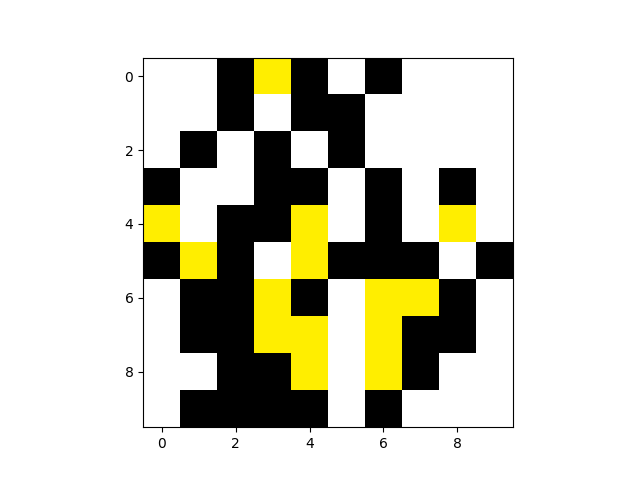

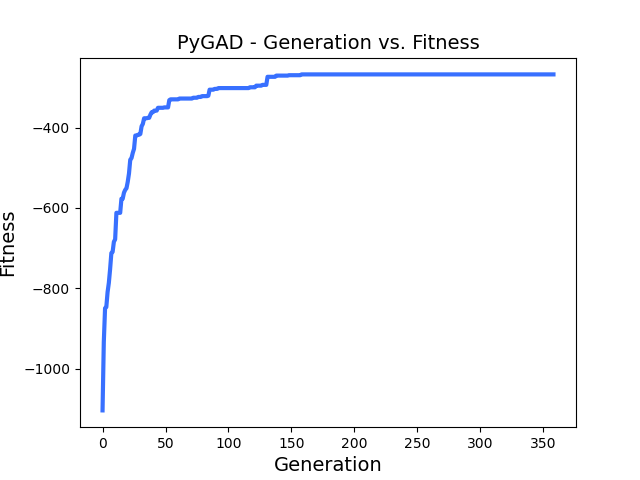

In [8]:
def runAlgorythmColorV2(verticalPattern, horizontalPattern, colors):
    height = len(horizontalPattern)
    width = len(verticalPattern)

    def gradeGenPatternColor(pattern):
        # pattern[i][0] początek bloku
        # pattern[i][0] + pattern[i][1] ostatni index zajmowany przez ten blok (długość bloku + 1 miejsce przerwy)
        grade = 0
        for i in range(len(pattern)):
            # prównywanie obecnego bloku do wszystkich poprzednich
            for j in range(i):
                if pattern[j][2] != pattern[i][2]:
                    if pattern[j][0] + pattern[j][1] - 1 >= pattern[i][0]: # odejmuje 1 żeby pozbyć się przerwy między blokami
                        grade -= 1000
                else:
                    if pattern[j][0] + pattern[j][1] >= pattern[i][0]:
                        grade -= 1000
        return grade

    def gradePaternsByColorLength(genPattern, pattern):
        # funkcja porównuje ile pixeli danego koloru jest w każdym wzorze
        grade = 0
        original = {}
        generated = {}
        for i in pattern: # i jest postaci [długość bloku, kolor]
            if i[1] in original:
                original[i[1]] = original[i[1]] + i[0]
            else:
                original[i[1]] = i[0]
        for i in genPattern:
            if i[1] in generated:
                generated[i[1]] = generated[i[1]] + i[0]
            else:
                generated[i[1]] = i[0]

        for i in original:
            if i in generated:
                grade -= abs(original[i] - generated[i])
                del generated[i]
            else:
                grade -= original[i]
        for i in generated:
            if i in original:
                grade -= abs(original[i] - generated[i])
            else:
                grade -= generated[i]

        return grade

    def gradeFuncColor(solution, pattern):
        # tworzenie "wzoru" z wygenerowanych wartości
        solutionPattern = [-1]
        for i in solution:
            if i == 0:
                solutionPattern.append(-1)
            else:
                if solutionPattern[-1] != -1:
                    solutionPattern[-1][0] = solutionPattern[-1][0] + 1
                else:
                    solutionPattern.append([1,i])
        filteredRowPatern = list(filter(lambda n: n != -1 , solutionPattern))
        # ocenianie wygenerowaniego "wzoru"
        grade = gradePaternsByColorLength(filteredRowPatern, pattern)

        for i in range(len(pattern)):
            if i < len(filteredRowPatern):
                if pattern[i] != filteredRowPatern[i]:
                    grade -= abs(pattern[i][0] - filteredRowPatern[i][0])
                    if pattern[i][1] != filteredRowPatern[i][1]: # wtedy gdy kolory są różne
                        grade -= pattern[i][0]
            else:
                grade -= pattern[i][0]

        if len(filteredRowPatern) > len(pattern):
            for i in range(len(filteredRowPatern) - len(pattern)):
                grade -= filteredRowPatern[i + len(pattern)][0]

        return grade

    def createImgColor(genes, height, width, horizontalPattern):
        img = np.full((height, width, 3), 255, dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            for j in horizontalPattern[i]:
                start = int(genes[index])
                if start + j[0] <= width :
                    for n in range(j[0]):
                        img[i][start + n] = colors[j[1]]
                else:
                    for n in range(width - start):
                        img[i][start + n] = colors[j[1]]
                index += 1
        
        return img

    def fitness_func(solution, solution_idx):
        fitness = 0
        # tworzenie macieży
        img = np.zeros((height, width), dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            generatedPattern = []
            for j in horizontalPattern[i]:
                start = int(solution[index])
                generatedPattern.append([solution[index], j[0], j[1]]) # [początek bloku, długość bloku, kolor bloku]
                if start + j[0] <= width : # sprawdzenie czy blok nie wychodzi poza obraz
                    for n in range(j[0]):
                        img[i][start + n] = j[1]
                else:
                    for n in range(width - start):
                        img[i][start + n] = j[1]
                    # odejmuj punkty gdy blok wychodzi poza wiersz
                    fitness -= abs(width - start - j[0])*10000
                index += 1
            fitness -= abs(gradeGenPatternColor(generatedPattern))
        # ocenianie kolumn
        for i in range(width):
            column = []
            for j in range(height):
                column.append(img[j][i])
            fitness += gradeFuncColor(column, verticalPattern[i])

        return fitness

    def getNumberOfBlocks(pattern):
        num = 0
        for i in pattern:
            num += len(i)
        return num

    gene_space = list(range(0, width))
    num_genes = getNumberOfBlocks(horizontalPattern)
    fitness_function = fitness_func
    sol_per_pop = 200

    num_parents_mating = 99
    num_generations = 5000
    keep_parents = 2
    parent_selection_type = "sss"
    crossover_type = "two_points"
    mutation_type = "random"
    mutation_percent_genes = getPercentageOfMutations(num_genes) # im mniejsza wartość tym lepiej

    stop_criteria = ["reach_0", "saturate_200"]

    ga_instance = pygad.GA(gene_space=gene_space,
                        num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_function,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes,
                        stop_criteria=stop_criteria)

    ga_instance.run()
    print("Generations:", ga_instance.generations_completed, "Fitness:", ga_instance.best_solution()[1])
    genes = ga_instance.best_solution()[0]

    img = createImgColor(genes, height, width, horizontalPattern)
    plt.imshow(img)

    if ga_instance.best_solution()[1] != 0:
        print("Mistakes in vertical paterns:")
        img = np.zeros((height, width), dtype=int)
        index = 0
        for i in range(len(horizontalPattern)):
            for j in horizontalPattern[i]:
                start = int(genes[index])
                if start + j[0] <= width :
                    for n in range(j[0]):
                        img[i][start + n] = j[1]
                else:
                    for n in range(width - start):
                        img[i][start + n] = j[1]
                index += 1
        for i in range(width):
            column = []
            for j in range(height):
                column.append(img[j][i])
            print(column, verticalPattern[i], gradeFuncColor(column, verticalPattern[i]))

    ga_instance.plot_fitness()
    plt.show()
    return ga_instance

runAlgorythmColorV1(verticalMColor10x10, horizontalMColor10x10, colors10x10)

# Podsumowanie

W rozwiązywaniu problemu najlepiej sprawdziły się algorytmy genetyczne. Algorytm typu rój cząstek znacznie częściej blokował się wpadając w minima lokalne funkcji fitness_func, mimo to rónież był w stanie rozwiązań nonogram wielkości 10x10, jednakże zajmowało mu to średnio 25 razy dłużej. Z moich eksperymentów również wynika to że mniejszy nonogram wcale nie musi być prostszy do rozwiązania, nonogram 10x10 "pszczoła" był dla obu algorytmów rozwiązujących kolorowe nonogramy cięższy do rozwiązania niż nonogram 15x14 "ptak".

Poniższe wykresy prezentują porównanie wszystkich opisanych powyżej algorytmów, gdzie:

- g1 = Pierwsza wersja algortmu genetycznego
- g2 = Druga wersja algortmu genetycznego
- r1 = Pierwsza wersja algortmu typu rój cząstek
- r2 = Druga wersja algortmu typu rój cząstek
- c1 = Pierwsza wersja algortmu genetycznego rozwiązującego kolorowe nonogramy
- c2 = Druga wersja algortmu genetycznego rozwiązującego kolorowe nonogramy

>Pierwszy jaśniejszy słupek na każdym wykresie oznacza wynik dla nonogramu 10x10, a drugi ciemniejszy słupek oznacza wynik dla nonogramu 15x15

Z wykresów wynika że Druga wersja algortmu genetycznego okazała się najlepsza, aczkolwiek Pierwsza wersja algortmu genetycznego uzyskała podobne wyniki.

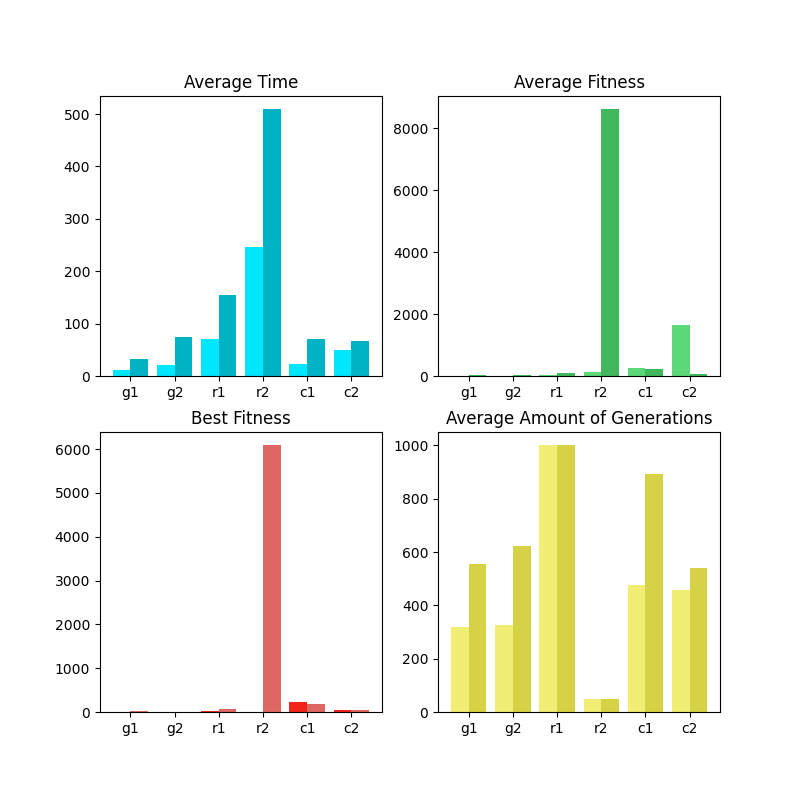

In [9]:
# algorytm = [avgTime, abs(avgFit), avgGen, abs(bestFit)]
a11 = [10.62, 4.74, 320.59, 0]
a12 = [33.3, 25.58, 556.23, 12]

a21 = [21.21, 6.18, 325.49, 0]
a22 = [75.1, 37.26, 622.75, 8]

a31 = [69.95, 34.2, 1000, 20]
a32 = [155.17, 94.6, 1000, 76]

a41 = [245.67, 117.4, 50, 0]
a42 = [509.06, 8606.8, 50, 6086]

a51 = [22.93, 269.7, 476.59, 230]
a52 = [70.64, 231.1, 891.1, 183]

a61 = [49.42, 1658.3, 456.7, 54]
a62 = [67.71, 55.7, 541.3, 45]
results10 = [a11,a21,a31,a41,a51,a61]
results15 = [a12,a22,a32,a42,a52,a62]
res10 = [[],[],[],[]]
res15 = [[],[],[],[]]
for i in range(6):
    res10[0].append(results10[i][0])
    res10[1].append(results10[i][1])
    res10[2].append(results10[i][2])
    res10[3].append(results10[i][3])
    res15[0].append(results15[i][0])
    res15[1].append(results15[i][1])
    res15[2].append(results15[i][2])
    res15[3].append(results15[i][3])

X = np.arange(len(res10[0]))

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.bar(X + 0.00, res10[0], color = '#00e6fc', width = 0.4)
plt.bar(X + 0.4, res15[0], color = '#00b3c4', width = 0.4)
plt.title("Average Time")
plt.xticks([r + 0.20 for r in range(len(res10[0]))], ['g1', 'g2', 'r1', 'r2', 'c1', 'c2'])

plt.subplot(2,2,2)
plt.bar(X + 0.00, res10[1], color = '#5bd978', width = 0.4)
plt.bar(X + 0.4, res15[1], color = '#42b85d', width = 0.4)
plt.title("Average Fitness")
plt.xticks([r + 0.20 for r in range(len(res10[1]))], ['g1', 'g2', 'r1', 'r2', 'c1', 'c2'])

plt.subplot(2,2,3)
plt.bar(X + 0.00, res10[3], color = '#f2251b', width = 0.4)
plt.bar(X + 0.4, res15[3], color = '#de6762', width = 0.4)
plt.title("Best Fitness")
plt.xticks([r + 0.20 for r in range(len(res10[3]))], ['g1', 'g2', 'r1', 'r2', 'c1', 'c2'])

plt.subplot(2,2,4)
plt.bar(X + 0.00, res10[2], color = '#f2ee74', width = 0.4)
plt.bar(X + 0.4, res15[2], color = '#d6d245', width = 0.4)
plt.title("Average Amount of Generations")
plt.xticks([r + 0.20 for r in range(len(res10[2]))], ['g1', 'g2', 'r1', 'r2', 'c1', 'c2'])

plt.show()

## Odnośnik do stron z których korzystałem:

- [Dokumentacja biblioteki pygad](http://pygad.readthedocs.io)
- [Dokumentacja biblioteki pyswarms](https://pyswarms.readthedocs.io)
- [Dokumentacja biblioteki numpy](https://numpy.org)
- [Dokumentacja biblioteki matplotlib](https://matplotlib.org)
- [Strona z której brałem nonogramy](https://www.nonograms.org)